This MMS case verifies the implementation of the Surface Kinetics boundary condition in FESTIM. We will consider a time-dependent case of hydrogen diffusion on domain $\Omega: x\in[0,1] \cup t\in[0, 5]$ with a homogeneous diffusion coefficient $D$, and a Dirichlet boundary condition on the rear domain side.

The problem is:

\begin{align}
    &\dfrac{\partial c_\mathrm{m}}{\partial t} = \nabla\cdot\left(D\nabla c_\mathrm{m} \right) + S \quad \textrm{ on } \Omega, \\
    &-D \nabla c_\mathrm{m} \cdot \mathbf{n} = \lambda_{\mathrm{IS}} \dfrac{\partial c_{\mathrm{m}}}{\partial t} + J_{\mathrm{bs}} - J_{\mathrm{sb}} \quad \textrm{ at } x=0, \\
    &c_\mathrm{m} = c_\mathrm{m, 0} \quad \textrm{ at } x=1, \\
    &c_\mathrm{m} = c_\mathrm{m, 0} \quad \textrm{ at } t=0, \\
    &\dfrac{d c_\mathrm{s}}{d t} = J_{\mathrm{bs}} - J_{\mathrm{sb}} + J_{\mathrm{vs}}  \quad \textrm{ at } x=0, \\
    &c_\mathrm{s}= c_\mathrm{s, 0}\quad \textrm{ at } t=0, \\
\end{align}

with $J_{\mathrm{bs}} = k_{\mathrm{bs}} c_{\mathrm{m}} \lambda_{\mathrm{abs}} \left(1 - \dfrac{c_\mathrm{s}}{n_{\mathrm{surf}}}\right)$, $J_{\mathrm{sb}} = k_{\mathrm{sb}} c_{\mathrm{s}} \left(1 - \dfrac{c_{\mathrm{m}}}{n_\mathrm{IS}}\right)$.

The manufactured exact solution for mobile concentration is:
\begin{equation*}
c_\mathrm{m, exact}=1+2x^2+x+2t.
\end{equation*}

For this problem, we choose:
\begin{align*}
& k_{\mathrm{bs}}=k_{\mathrm{sb}}=1/\lambda_{\mathrm{abs}} \\
& n_{\mathrm{IS}} = 100 \\
& n_{\mathrm{surf}} = 5 \\
& D = 2 \\
& \lambda_{IS} = 10
\end{align*}

Injecting these parameters and the exact solution for solute H, we obtain:

\begin{align*}
& S = 2(1-2D) \\
& J_{\mathrm{vs}}=2\frac{n_{\mathrm{surf}}}{n_\mathrm{IS}}+2\lambda_\mathrm{IS}-D \\
& c_\mathrm{s, exact}=\frac{n_{\mathrm{surf}}}{n_\mathrm{IS}}\left( 1+2t+2\lambda_{\mathrm{IS}}-D\right) \\
& c_\mathrm{s,0}=c_\mathrm{s, exact} \\
& c_\mathrm{m,0}=c_\mathrm{m, exact}
\end{align*}

We can then run a FESTIM model with these values and compare the numerical solutions with $c_\mathrm{m, exact}$ and $c_\mathrm{s, exact}$.

In [2]:
import festim as F
import matplotlib.pyplot as plt
import numpy as np

# Create and mark the mesh


# Create the FESTIM model
my_model = F.Simulation()

my_model.mesh = F.MeshFromVertices(np.linspace(0,1,100))

# Variational formulation
n_IS = 20
n_surf = 5
D = 2
lambda_IS = 10


exact_solution_cm = lambda x, t: 1 + 2 * x**2 + x + 2 * t
exact_solution_cs = lambda t: n_surf * (1 + 2 * t + 2 * lambda_IS - D) / n_IS

k_bs = n_IS / n_surf
k_sb = n_IS / n_surf

solute_source = 2 * (1 - 2 * D)

my_model.sources = [F.Source(solute_source, volume=1, field="solute")]

my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[2], value=exact_solution_cm(x=F.x, t=F.t), field="solute"),
    F.SurfaceKinetics(
        k_sb=k_sb,
        k_bs=k_bs,
        lambda_IS=lambda_IS,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=n_surf * 2 / n_IS + 2 * lambda_IS - D,
        surfaces=1,
        initial_condition=exact_solution_cs(t=0),
    ),
]

my_model.initial_conditions = [F.InitialCondition(field="solute", value=exact_solution_cm(x=F.x, t=0))]

my_model.materials = F.Material(id=1, D_0=D, E_D=0)

my_model.T = 300

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=True,
    final_time=5
)

my_model.dt = F.Stepsize(0.01)

export_times = [1,3,5]
my_model.exports = [
    F.TXTExport("solute", filename="./mobile_conc.txt", times=export_times),
    F.DerivedQuantities([F.AdsorbedHydrogen(surface=1)]),
]

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:373: UserWarning: <class 'festim.exports.derived_quantities.adsorbed_hydrogen.AdsorbedHydrogen'> may not work as intended for cartesian meshes
  warnings.warn(
/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:405: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        5.0e+00 s    Elapsed time so far: 6.7 s


## Comparison with exact solution

Text(0.5, 0, 'x')

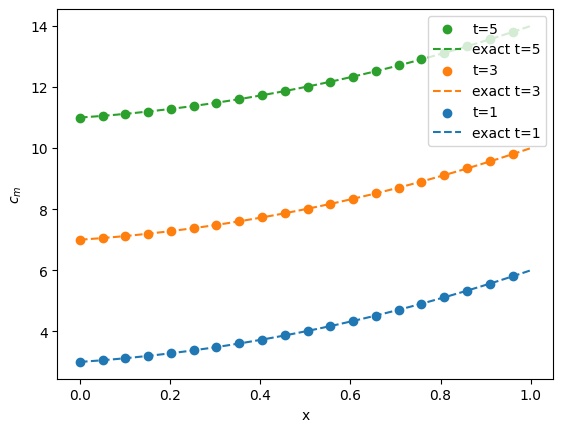

In [3]:
data = np.genfromtxt("mobile_conc.txt", names=True, delimiter=",")
for t in export_times:
    x = data["x"]
    y = data[f"t{t:.2e}s".replace(".", "").replace("+", "")]
    # order y by x
    x, y = zip(*sorted(zip(x, y)))

    (l1,) = plt.plot(
        x,
        exact_solution_cm(np.array(x), t),
        "--",
        label=f"exact t={t}",
    )
    plt.scatter(
        x[::10],
        y[::10],
        label=f"t={t}",
        color=l1.get_color(),
    )

plt.legend(reverse=True)
plt.ylabel("$c_m$")
plt.xlabel("x")

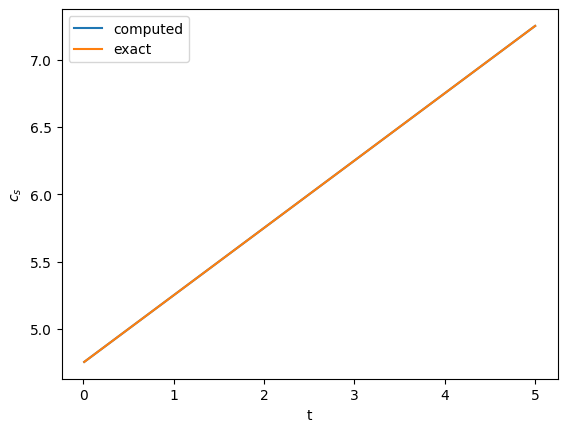

In [4]:
plt.figure()
c_s_computed = my_model.exports[1][0].data
t = my_model.exports[1][0].t

plt.plot(t, c_s_computed, label="computed")
plt.plot(t, exact_solution_cs(np.array(t)), label="exact")
plt.ylabel("$c_s$")
plt.xlabel("t")
plt.legend()
plt.show()